In [ ]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

In [ ]:
sc.install_pypi_package('boto3', 'https://pypi.org/simple')
sc.install_pypi_package('matplotlib==3.2.1', 'https://pypi.org/simple')
sc.install_pypi_package('pandas==1.0.5', 'https://pypi.org/simple')
sc.install_pypi_package('scipy==1.4.1', 'https://pypi.org/simple')
sc.install_pypi_package('seaborn==0.11.1', 'https://pypi.org/simple')

In [35]:
import boto3
import matplotlib.pyplot as plt
import pyspark.sql.functions as f
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor 
from functools import reduce
from pyspark.sql import DataFrame

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
data = spark.read.parquet('s3://wos-bucket/PurchaseOrder.xml.parquet')
data.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- purchaseOrder: struct (nullable = true)
 |    |-- purchaseOrder@orderDate: timestamp (nullable = true)
 |    |-- shipTo: struct (nullable = true)
 |    |    |-- shipTo@country: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- street: string (nullable = true)
 |    |    |-- city: string (nullable = true)
 |    |    |-- state: string (nullable = true)
 |    |    |-- zip: double (nullable = true)
 |    |-- billTo: struct (nullable = true)
 |    |    |-- billTo@country: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- street: string (nullable = true)
 |    |    |-- city: string (nullable = true)
 |    |    |-- state: string (nullable = true)
 |    |    |-- zip: double (nullable = true)
 |    |-- comment: string (nullable = true)
 |    |-- items: struct (nullable = true)
 |    |    |-- item: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- item@partNu

In [9]:
par_files = ['s3://wos-bucket/PurchaseOrder.xml.parquet',
             's3://wos-bucket/p2.parquet',
             's3://wos-bucket/p3.parquet']

# Define read function
def from_s3(file):
    return spark.read.parquet(file)
    
# Read test Parquet files from S3 in parallel
with ThreadPoolExecutor(max_workers = 3) as executor:
    results = executor.map(from_s3, par_files)
    
df1, df2, df3 = results

# Combine files into a single dataframe
# From https://stackoverflow.com/questions/37612622/spark-unionall-multiple-dataframes
dfs = [df1, df2, df3]
new_data = reduce(DataFrame.unionAll, dfs)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
# Load user data to demo analysis with nested dataframes
json_df = spark.read.json('s3://wos-bucket/users_1k.json', multiLine=True,) 
json_df.write.parquet('./users_1k.parquet')
df = spark.read.parquet('./users_1k.parquet')
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- age: long (nullable = true)
 |-- city: string (nullable = true)
 |-- friends: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- hobbies: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |-- id: long (nullable = true)
 |-- name: string (nullable = true)

In [74]:
# Plot user age distribution
age = df. \
    withColumn(
        'bracket', 
        f.expr('''
            CASE 
            WHEN age < 20 THEN ' <20'
            WHEN age BETWEEN 20 AND 39 THEN '20-39'
            WHEN age BETWEEN 40 AND 59 THEN '40-59'
            WHEN age BETWEEN 60 AND 79 THEN '60-79'
            ELSE '80+'
            END
            '''))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [75]:
age.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+-------------+--------------------+---+--------+-------+
|age|         city|             friends| id|    name|bracket|
+---+-------------+--------------------+---+--------+-------+
| 78|       Austin|[[[Watching Sport...|  0|  Elijah|  60-79|
| 97|       Boston|[[[Watching Sport...|  1|    Noah|    80+|
| 48|    San Diego|[[[Reading, Volun...|  2|     Evy|  40-59|
| 39|    St. Louis|[[[Watching Sport...|  3|  Oliver|  20-39|
| 95|    St. Louis|[[[Movie Watching...|  4| Michael|    80+|
| 19|     Portland|[[[Painting, Tele...|  5| Michael|    <20|
| 76|       Austin|[[[Genealogy, Coo...|  6|   Lucas|  60-79|
| 25|  San Antonio|[[[Music, Golf], ...|  7|Michelle|  20-39|
| 61|       Austin|[[[Bicycling, Ski...|  8|   Emily|  60-79|
| 33|  New Orleans|[[[Traveling, Bic...|  9|    Liam|  20-39|
| 59|  New Orleans|[[[Video Games, F...| 10|    Levi|  40-59|
| 82|     Portland|[[[Jewelry Making...| 11|   Lucas|    80+|
| 82|   Charleston|[[[Eating Out], O...| 12|   Kevin|    80+|
| 34|  S

In [76]:
age = age.groupby('bracket') \
    .count() \
    .orderBy('bracket')
age.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----+
|bracket|count|
+-------+-----+
|    <20|   26|
|  20-39|  238|
|  40-59|  234|
|  60-79|  262|
|    80+|  240|
+-------+-----+

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

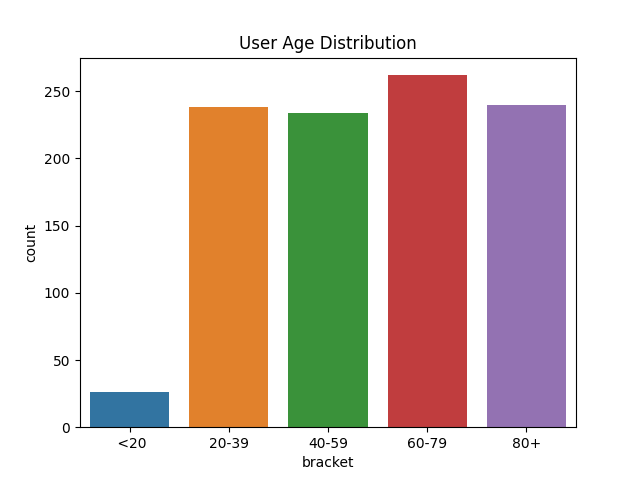

In [80]:
age_p = age.toPandas()

plt.close()

sns.barplot(x = 'bracket', y = 'count', data = age_p)
plt.title('User Age Distribution')

%matplot plt

In [109]:
# ID distinct friend names
friends = df.select(f.col('friends.name'))
friends.show()
df.withColumn('names', f.explode('friends.name')).select('names').groupBy('names').count().orderBy('count', ascending = False).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|                name|
+--------------------+
|  [Michelle, Robert]|
|[Oliver, Olivia, ...|
|[Joe, Joe, Oliver...|
|[Mateo, Nora, Ava...|
|      [Mateo, Chris]|
|[Jack, Oliver, Ch...|
|        [John, John]|
|[Jack, Daniel, Ro...|
|[Nora, Ava, Ameli...|
| [Chloe, Evy, Grace]|
|       [Noah, Sarah]|
|   [Luke, Noah, Evy]|
|   [Oliver, Michael]|
|      [Daniel, Zoey]|
|[Michelle, Daniel...|
| [Joe, Mateo, Mateo]|
|[Amelia, Michael,...|
|[Emily, Sophie, C...|
|[Emma, Emma, Dani...|
|[Leo, Emma, Sarah...|
+--------------------+
only showing top 20 rows

+---------+-----+
|    names|count|
+---------+-----+
|  Michael|  134|
|     Noah|  130|
|    Emily|  129|
| Victoria|  129|
|    Sarah|  126|
|     John|  126|
|    Chloe|  126|
|   Amelia|  126|
| Michelle|  124|
|      Joe|  121|
|     Emma|  121|
|    Chris|  120|
|   Olivia|  120|
|     Levi|  119|
|    Grace|  116|
|      Ava|  116|
|     Nora|  116|
|      Leo|  115|
|   Camila|  115|
|Charlotte|  115|
+-------